In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as aconst
import time
import pickle
import os
from pycbc.types import timeseries, frequencyseries
from calcwf import *

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


# Generate training data

In [2]:
# Generates n training waveforms equally spaced in true anomaly
def gen_training_wfs(f_low, e, M, q, n, sample_rate, approximant):

    training_wfs = []
    latest_time = -np.inf
    latest_id = None
    # Generate all training waveforms
    for i in range(n):

        # Create waveform
        h = gen_wf(f_low, e, M, q, sample_rate, approximant, phase=0, TA=i*2*np.pi/n, freq_type='orbitaveraged')
        training_wfs.append(h)    
        if h.sample_times[0] > latest_time:
            latest_time = h.sample_times[0]
            latest_id = i            

        # Progress bar
        print(f'\rCreated {i+1} out of {n} waveforms.', end='')

    # Trim and resize wfs
    print('\nTrimming and resizing waveforms.')
    for i in range(len(training_wfs)):
        training_wfs[i] = trim_wf(training_wfs[i], training_wfs[latest_id])
    training_wfs = resize_wfs(training_wfs)
    print('Done.')

    return training_wfs

In [3]:
training_wfs = gen_training_wfs(10, 0.2, chirp2total(24, 2), 2, 100, 4096, 'TEOBResumS')

Created 100 out of 100 waveforms.
Trimming and resizing waveforms.
Done.


/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


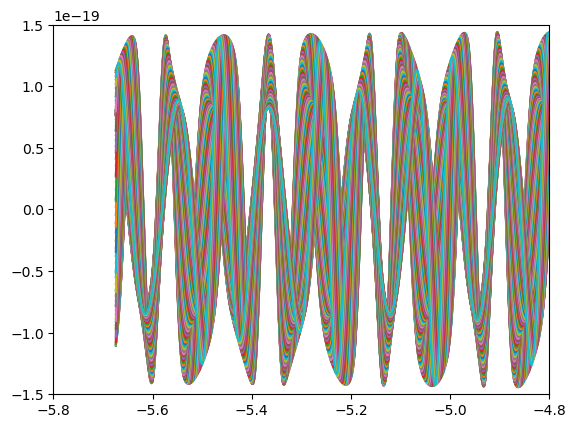

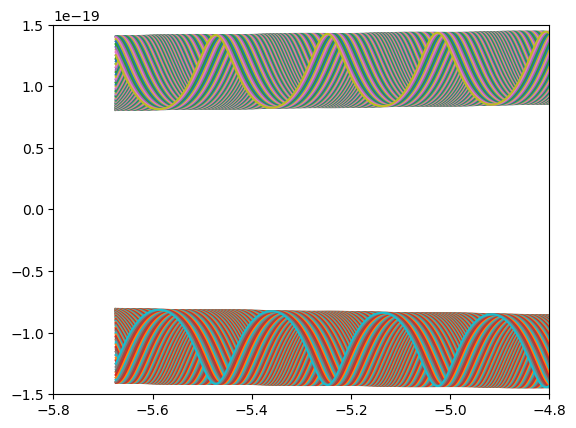

In [4]:
for wf in training_wfs:
    plt.plot(wf.sample_times, wf)
plt.xlim(-5.8,-4.8)
plt.ylim(-1.5e-19,1.5e-19)
plt.show()

for wf in training_wfs:
    plt.plot(wf.sample_times, np.sqrt(wf.real()**2+wf.imag()**2))
    plt.plot(wf.sample_times, -np.sqrt(wf.real()**2+wf.imag()**2))
plt.xlim(-5.8,-4.8)
plt.ylim(-1.5e-19,1.5e-19)
plt.show()

In [5]:
def whiten_wfs(wfs, f_low):

    # Generate psd
    psd = gen_psd(wfs[0], f_low)
    delta_f = psd.delta_f

    # Set zero values to 'inf'
    psd = np.array(psd)
    psd[psd==0]=1
    psd = frequencyseries.FrequencySeries(psd, delta_f)

    # Whiten each wf
    whiten = []
    for wf in wfs:
        hp = (wf.real().to_frequencyseries() / psd ** 0.5).to_timeseries()
        hc = (-wf.imag().to_frequencyseries() / psd ** 0.5).to_timeseries()
        whiten.append(hp-1j*hc)

    return whiten

In [6]:
white_training_wfs = whiten_wfs(training_wfs, 10)

# Performing SVD

In [7]:
# Convert training wf data to np array in right shape/form and calc svd
start = time.time()
X = np.array(white_training_wfs).T
means = X.mean(axis=0) 
stds = X.std(axis=0) 
U, S, Vh = np.linalg.svd((X-means)/stds)
end = time.time()
print(f'Time taken: {end-start} seconds')

Time taken: 300.428528547287 seconds


In [8]:
pcs = Vh

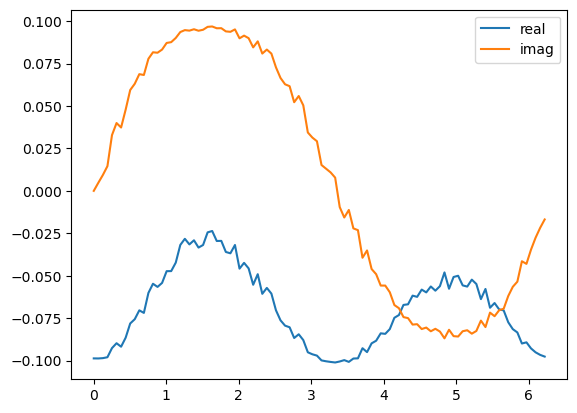

In [14]:
# Plot magnitudes as a function of TA
plt.plot(np.linspace(0,2*np.pi,100,endpoint=False), np.real(pcs[0]), label='real')
plt.plot(np.linspace(0,2*np.pi,100,endpoint=False), np.imag(pcs[0]), label='imag')
plt.legend()

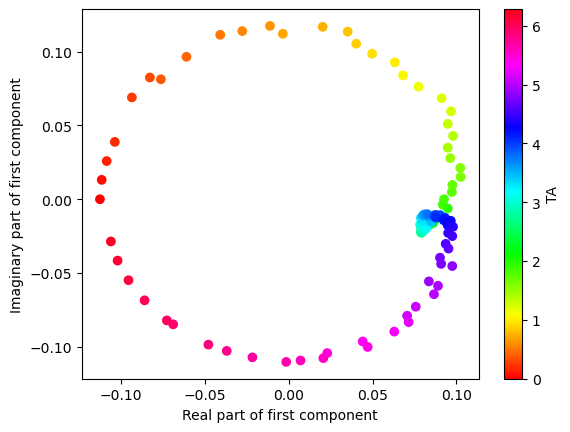

In [10]:
# Plot of complex parts of first direction
colors = np.linspace(0,2*np.pi,100,endpoint=False)
plt.scatter(np.real(pcs[1]), np.imag(pcs[1]), c=colors, vmin=0, vmax=2*np.pi, cmap='hsv')
plt.xlabel('Real part of first component')
plt.ylabel('Imaginary part of first component')
plt.colorbar(label='TA')

In [11]:
rel_imports = []
for i in range(10):
    rel_imports.append(S[i]**2/np.sum(S**2))
    print('Component {} contains {:.5f}% of the total information.'.format(i, rel_imports[i]*100))

print('\n')
print('Components 0 and 1 combined contain {:.5f}% of the total information.'.format((rel_imports[0]+rel_imports[1])*100))

Component 0 contains 92.84956% of the total information.
Component 1 contains 5.81245% of the total information.
Component 2 contains 0.75838% of the total information.
Component 3 contains 0.47016% of the total information.
Component 4 contains 0.05418% of the total information.
Component 5 contains 0.04833% of the total information.
Component 6 contains 0.00527% of the total information.
Component 7 contains 0.00068% of the total information.
Component 8 contains 0.00051% of the total information.
Component 9 contains 0.00036% of the total information.


Components 0 and 1 combined contain 98.66202% of the total information.


In [16]:
V = Vh.T.conj()
inv_S = 1/S
Vinv_S = np.matmul(V, np.diag(inv_S))
unwhite_wfs = np.matmul(np.array(training_wfs).T, Vinv_S).T

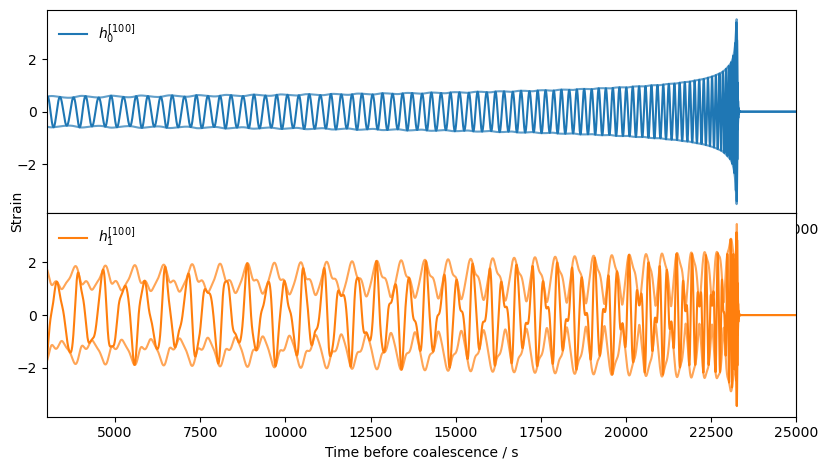

In [23]:
plt.figure(figsize=(1.3*6.4,4.8))
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(unwhite_wfs[0])), unwhite_wfs[0]*1e21, c='C0', label='$h_0^{[100]}$')
plt.plot(np.arange(len(unwhite_wfs[0])), abs(unwhite_wfs[0])*1e21, c='C0', alpha=0.7)
plt.plot(np.arange(len(unwhite_wfs[0])), -abs(unwhite_wfs[0])*1e21, c='C0', alpha=0.7)
plt.xlim(3000,25000)
ylims = plt.gca().get_ylim()
plt.legend(loc='upper left', frameon=False)
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(unwhite_wfs[1])), unwhite_wfs[2]*1e21, c='C1', label='$h_1^{[100]}$')
plt.plot(np.arange(len(unwhite_wfs[1])), abs(unwhite_wfs[2])*1e21, c='C1', alpha=0.7)
plt.plot(np.arange(len(unwhite_wfs[1])), -abs(unwhite_wfs[2])*1e21, c='C1', alpha=0.7)
plt.ylim(ylims)
plt.xlim(3000,25000)
plt.legend(loc='upper left', frameon=False)
plt.gcf().text(0.01, 0.55, 'Strain', va='center', rotation='vertical')
plt.xlabel('Time before coalescence / s')
plt.tight_layout()
plt.subplots_adjust(hspace=0)

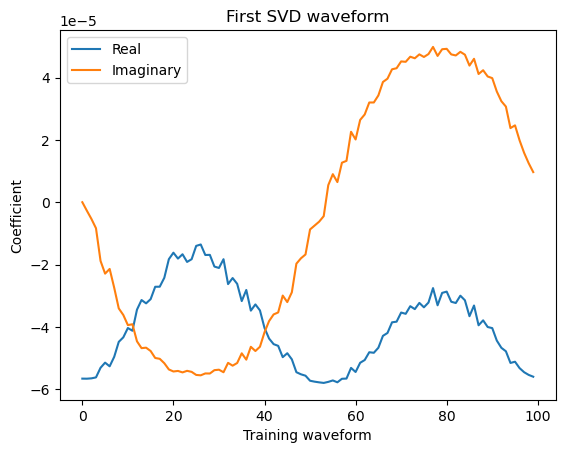

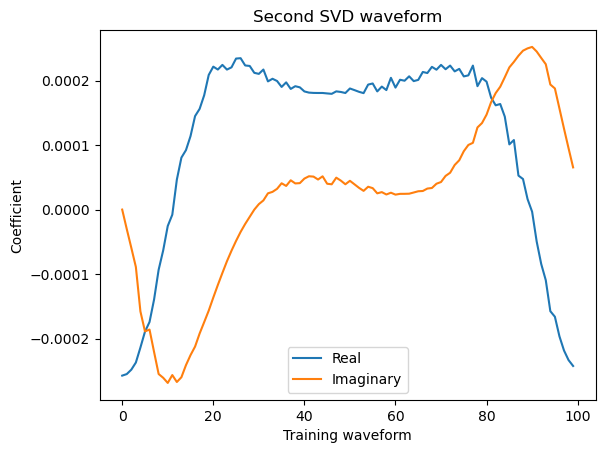

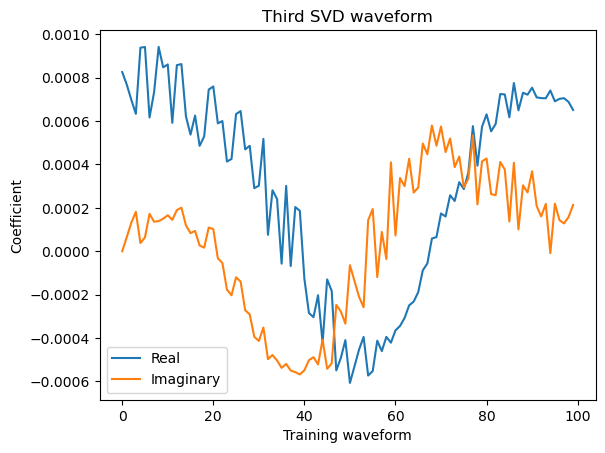

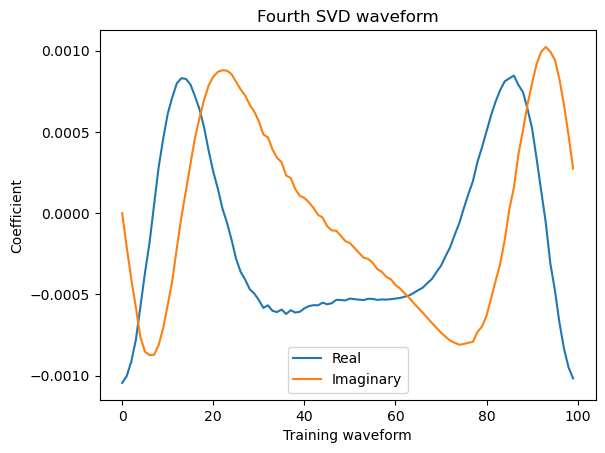

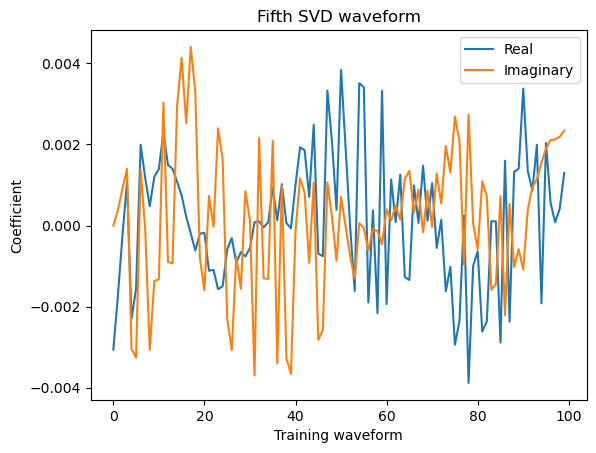

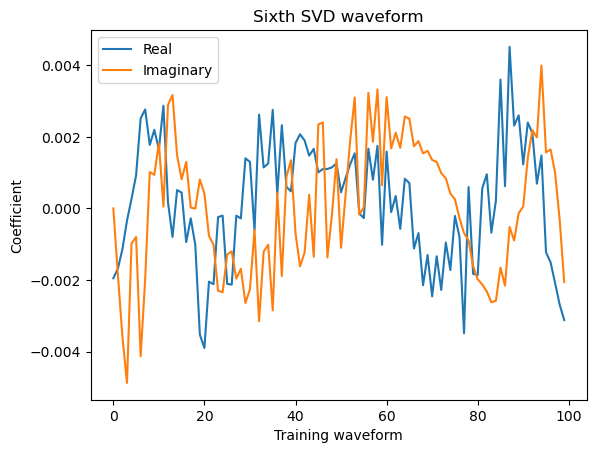

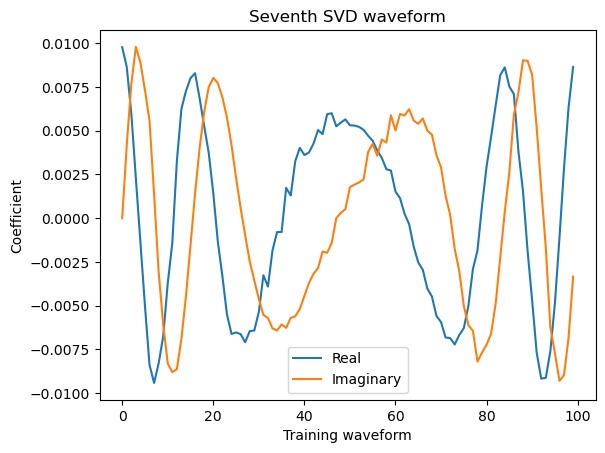

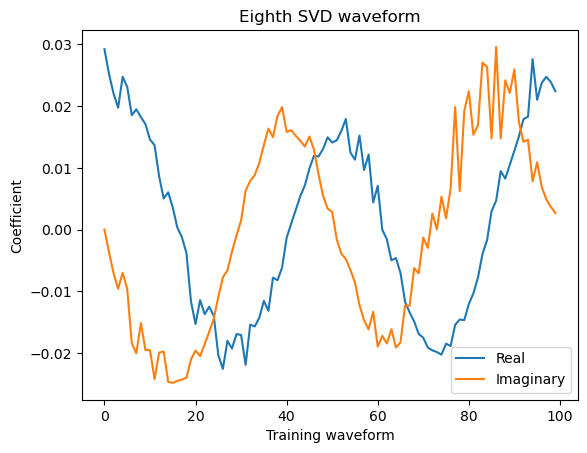

In [22]:
names = ['First', 'Second', 'Third', 'Fourth', 'Fifth', 'Sixth', 'Seventh', 'Eighth']

for i, name in enumerate(names):
    plt.plot(np.arange(len(Vinv_S.T[i])), np.real(Vinv_S.T[i]), label='Real')
    plt.plot(np.arange(len(Vinv_S.T[i])), np.imag(Vinv_S.T[i]), label='Imaginary')
    plt.title(f'{name} SVD waveform')
    plt.xlabel('Training waveform')
    plt.ylabel('Coefficient')
    plt.legend()
    plt.show()